### Experiment 2 

In [1]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets 
from torch.utils.data import DataLoader
# from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os 

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:1


In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

class CustomImageListDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, class_to_idx, transform=None):
        with open(file_list, "r") as f:
            self.samples = [line.strip() for line in f]
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        class_folder = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx.get(class_folder, -1)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ---------------- Create a combined class mapping ----------------
root_dir = "dataset/imagenet_tests"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Collect class mappings from all 10 partitions
combined_class_to_idx = {}
for i in range(1, 11):
    test_dir = os.path.join(root_dir, f"test{i}")
    dataset = datasets.ImageFolder(test_dir, transform=transform)
    combined_class_to_idx.update(dataset.class_to_idx)

print(f"✅ Combined class mapping built: {len(combined_class_to_idx)} total classes")

# ---------------- Load your 1000-image subset ----------------
subset_file = "results/hard_cases_missed_by_mobilenet.txt"
hard_dataset = CustomImageListDataset(subset_file, class_to_idx=combined_class_to_idx, transform=transform)
hard_loader = DataLoader(hard_dataset, batch_size=1, shuffle=False)

print(f"✅ Loaded {len(hard_dataset)} hard samples")

✅ Combined class mapping built: 1000 total classes
✅ Loaded 1000 hard samples


In [4]:
def get_models(dataset, model_name, key): 
    if dataset == 'imagenet':
        # save_root_path = r"checkpoint/tinyimagenet"
        model = timm.create_model(model_name, pretrained=True, num_classes=1000).to(device)
        model.eval()
        if 'inc' in key or 'vit' in key or 'bit' in key:
            return torch.nn.Sequential(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), model)
        else:
            return torch.nn.Sequential(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), model)

In [5]:
hard_dataset

### Ensemble Attack 

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn

def clip_by_tensor(t, t_min, t_max):
    """
    clip_by_tensor
    :param t: tensor
    :param t_min: min
    :param t_max: max
    :return: cliped tensor
    """
    result = (t >= t_min).float() * t + (t < t_min).float() * t_min
    result = (result <= t_max).float() * result + (result > t_max).float() * t_max
    return result

class Weight_Selection(nn.Module):
    def __init__(self, weight_len) -> None:
        super(Weight_Selection,self).__init__()
        self.weight = nn.parameter.Parameter(torch.ones([weight_len]))

    def forward(self, x, index):
        x = self.weight[index] * x
        return x

def MI_FGSM_SMER(surrogate_models,images, labels, args,num_iter = 10):
    eps = args.eps/255.0
    alpha = args.alpha/255.0
    beta = alpha
    momentum = args.momentum
    image_min = clip_by_tensor(images - eps, 0.0, 1.0)
    image_max = clip_by_tensor(images + eps, 0.0, 1.0)
    m = len(surrogate_models) 
    m_smer = m*4
    weight_selection = Weight_Selection(m).to(images.device)
    optimizer = torch.optim.SGD(weight_selection.parameters(),lr=2e-2,weight_decay=2e-3)
    noise = 0
    grad = 0
    for i in range(num_iter):
        if images.grad is not None:
            images.grad.zero_()
        images = Variable(images, requires_grad = True)
        x_inner = images.detach()
        x_before = images.clone()
        noise_inner_all = torch.zeros([m_smer, *images.shape]).to(images.device)
        grad_inner = torch.zeros_like(images)
        options = []
        for i in range(int(m_smer / m)):
            options_single=[j for j in range(m)]
            np.random.shuffle(options_single)
            options.append(options_single)
        options = np.reshape(options,-1)
        for j in range(m_smer):
            option = options[j]
            grad_single = surrogate_models[option]
            x_inner.requires_grad = True
            out_logits = grad_single(x_inner)
            if type(out_logits) is list:
                out = weight_selection(out_logits[0],option)
                aux_out = weight_selection(out_logits[1],option)
            else:
                out = weight_selection(out_logits,option)
            loss = F.cross_entropy(out, labels)
            if type(out_logits) is list:
                loss = loss + F.cross_entropy(aux_out, labels)
            noise_im_inner = torch.autograd.grad(loss,x_inner)[0]
            group_logits = 0
            group_aux_logits = 0
            for m_step, model_s in enumerate(surrogate_models):
                out_logits = model_s(x_inner)
                if type(out_logits) is list:
                    logits = weight_selection(out_logits[0],m_step)
                    aux_logits = weight_selection(out_logits[1],m_step)
                else:
                    logits = weight_selection(out_logits,m_step)
                group_logits = group_logits + logits / m
                if type(out_logits) is list:
                    group_aux_logits = group_aux_logits + aux_logits / m
            loss = F.cross_entropy(group_logits,labels)
            if type(out_logits) is list:
                loss = loss + F.cross_entropy(group_aux_logits,labels)
            outer_loss = -torch.log(loss)
            x_inner.requires_grad = False
            outer_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            noise_inner = noise_im_inner
            noise_inner = noise_inner / torch.mean(torch.abs(noise_inner), dim=[1, 2, 3], keepdims=True)
            grad_inner = grad_inner + noise_inner
            x_inner = x_inner + beta * torch.sign(grad_inner)
            x_inner = clip_by_tensor(x_inner, image_min, image_max)
            noise_inner_all[j] = grad_inner.clone()
        noise =noise_inner_all[-1].clone() 
        noise = noise / torch.mean(torch.abs(noise), dim=[1, 2, 3], keepdims=True)
        grad = noise + momentum * grad
        images = x_before +  alpha * torch.sign(grad)
        images = clip_by_tensor(images, image_min, image_max)
    return images

def I_FGSM_SMER(surrogate_models,images, labels, args,num_iter = 10):
    eps = args.eps/255.0
    alpha = args.alpha/255.0
    beta = alpha
    image_min = clip_by_tensor(images - eps, 0.0, 1.0)
    image_max = clip_by_tensor(images + eps, 0.0, 1.0)
    m = len(surrogate_models) 
    m_smer = m*4
    weight_selection = Weight_Selection(m).to(images.device)
    optimizer = torch.optim.SGD(weight_selection.parameters(),lr=2e-2,weight_decay=2e-3)
    grad = 0
    for _ in range(num_iter):
        if images.grad is not None:
            images.grad.zero_()
        images = Variable(images, requires_grad = True)
        x_inner = images.detach()
        x_before = images.clone()
        noise_inner_all = torch.zeros([m_smer, *images.shape]).to(images.device)
        grad_inner = torch.zeros_like(images)
        options = []
        for _ in range(int(m_smer / m)):
            options_single=[j for j in range(m)]
            np.random.shuffle(options_single)
            options.append(options_single)
        options = np.reshape(options,-1)
        for j in range(m_smer):
            option = options[j]
            grad_single = surrogate_models[option]
            x_inner.requires_grad = True
            out_logits = grad_single(x_inner)
            if type(out_logits) is list:
                out = weight_selection(out_logits[0],option)
                aux_out = weight_selection(out_logits[1],option)
            else:
                out = weight_selection(out_logits,option)
            loss = F.cross_entropy(out, labels)
            if type(out_logits) is list:
                loss = loss + F.cross_entropy(aux_out, labels)
            noise_im_inner = torch.autograd.grad(loss,x_inner)[0]
            group_logits = 0
            group_aux_logits = 0
            for m_step, model_s in enumerate(surrogate_models):
                out_logits = model_s(x_inner)
                if type(out_logits) is list:
                    logits = weight_selection(out_logits[0],m_step)
                    aux_logits = weight_selection(out_logits[1],m_step)
                else:
                    logits = weight_selection(out_logits,m_step)
                group_logits = group_logits + logits / m
                if type(out_logits) is list:
                    group_aux_logits = group_aux_logits + aux_logits / m
            loss = F.cross_entropy(group_logits,labels)
            if type(out_logits) is list:
                loss = loss + F.cross_entropy(group_aux_logits,labels)
            outer_loss = -torch.log(loss)
            x_inner.requires_grad = False
            outer_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            noise_inner = noise_im_inner
            noise_inner = noise_inner / torch.mean(torch.abs(noise_inner), dim=[1, 2, 3], keepdims=True)
            grad_inner = grad_inner + noise_inner
            x_inner = x_inner + beta * torch.sign(grad_inner)
            x_inner = clip_by_tensor(x_inner, image_min, image_max)
            noise_inner_all[j] = grad_inner.clone()
        grad =noise_inner_all[-1].clone()
        images = x_before +  alpha * torch.sign(grad)
        images = clip_by_tensor(images, image_min, image_max)
    return images

In [7]:
def PGD_SMER(surrogate_models, images, labels, args, num_iter=10):
    eps = args.eps / 255.0
    alpha = args.alpha / 255.0  # step size
    beta = alpha                # inner step
    image_min = clip_by_tensor(images - eps, 0.0, 1.0)
    image_max = clip_by_tensor(images + eps, 0.0, 1.0)

    m = len(surrogate_models)
    m_smer = m * 4

    weight_selection = Weight_Selection(m).to(images.device)
    optimizer = torch.optim.SGD(weight_selection.parameters(), lr=2e-2, weight_decay=2e-3)

    for t in range(num_iter):
        if images.grad is not None:
            images.grad.zero_()

        images = Variable(images, requires_grad=True)
        x_before = images.clone()

        noise_inner_all = torch.zeros([m_smer, *images.shape]).to(images.device)
        grad_inner = torch.zeros_like(images)

        # build random permutation groups
        options = []
        for i in range(int(m_smer / m)):
            perm = list(range(m))
            np.random.shuffle(perm)
            options.append(perm)
        options = np.reshape(options, -1)

        x_inner = images.detach()

        # SMER multi-model inner optimization
        for j in range(m_smer):
            option = options[j]
            grad_single = surrogate_models[option]

            x_inner.requires_grad = True
            out_logits = grad_single(x_inner)

            if isinstance(out_logits, list):
                out = weight_selection(out_logits[0], option)
                aux_out = weight_selection(out_logits[1], option)
                loss = F.cross_entropy(out, labels) + F.cross_entropy(aux_out, labels)
            else:
                out = weight_selection(out_logits, option)
                loss = F.cross_entropy(out, labels)

            # compute single-model gradient
            noise_single = torch.autograd.grad(loss, x_inner)[0]

            # SMER group-level gradient
            group_logits = 0
            group_aux_logits = 0

            for m_step, model_s in enumerate(surrogate_models):
                logit_s = model_s(x_inner)

                if isinstance(logit_s, list):
                    logits = weight_selection(logit_s[0], m_step)
                    aux_logits = weight_selection(logit_s[1], m_step)
                    group_aux_logits += aux_logits / m
                else:
                    logits = weight_selection(logit_s, m_step)

                group_logits += logits / m

            loss_group = F.cross_entropy(group_logits, labels)
            if isinstance(logit_s, list):
                loss_group += F.cross_entropy(group_aux_logits, labels)

            # SMER outer optimization
            outer_loss = -torch.log(loss_group)
            x_inner.requires_grad = False

            outer_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # normalize gradient
            noise_single = noise_single / (torch.mean(torch.abs(noise_single), dim=[1,2,3], keepdims=True) + 1e-8)
            grad_inner = grad_inner + noise_single

            # PGD inner update (REAL gradient, not sign)
            x_inner = x_inner + beta * grad_inner
            x_inner = clip_by_tensor(x_inner, image_min, image_max)

            noise_inner_all[j] = grad_inner.clone()

        # final gradient used for PGD update
        final_grad = noise_inner_all[-1]
        final_grad = final_grad / (torch.mean(torch.abs(final_grad), dim=[1,2,3], keepdims=True) + 1e-8)

        # PGD update: add raw gradient
        images = x_before + alpha * final_grad

        # project back to L∞ ball
        images = clip_by_tensor(images, image_min, image_max)

    return images


In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn

# --- helper: gaussian kernel for TI smoothing ---
def get_gaussian_kernel_torch(kernel_size: int = 5, sigma: float = None, channels: int = 3, device='cpu', dtype=torch.float32):
    if sigma is None:
        sigma = kernel_size / 3.0
    ax = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, device=device, dtype=dtype)
    xx, yy = torch.meshgrid(ax, ax, indexing='xy')
    kernel = torch.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
    kernel = kernel / kernel.sum()
    kernel = kernel.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)  # grouped conv: (C,1,k,k)
    return kernel

# --- helper: Diverse Input transform (random resize + pad/crop) ---
def DI_transform_torch(x: torch.Tensor, prob: float = 0.7, diversity_scale: float = 0.12):
    """Apply DI transform with probability prob. x shape (B,C,H,W)."""
    if torch.rand(1).item() > prob:
        return x
    B, C, H, W = x.shape
    s = float(diversity_scale)
    rnd = int(H * (1.0 - s) + torch.rand(1).item() * H * s)
    rnd = max(1, rnd)
    x_resized = F.interpolate(x, size=(rnd, rnd), mode='bilinear', align_corners=False)
    if rnd < H:
        pad_h = H - rnd
        pad_w = W - rnd
        pad_top = pad_h // 2
        pad_left = pad_w // 2
        pad_bottom = pad_h - pad_top
        pad_right = pad_w - pad_left
        x_padded = F.pad(x_resized, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0.0)
        return x_padded
    elif rnd > H:
        start = (rnd - H) // 2
        return x_resized[:, :, start:start + H, start:start + W]
    else:
        return x_resized

# ---------- TI-DIM variants of your functions ----------

def MI_TIDIM_SMER(surrogate_models, images, labels, args, num_iter=10,
                  kernel_size=5, di_prob=0.7, diversity_scale=0.12, n_inner_repeat=4):
    """
    MI + TI + DIM version that follows your SMER structure.
    - surrogate_models: list of models
    - images: (B,C,H,W), values in [0,1]
    - labels: (B,)
    - args has eps, alpha, momentum
    - num_iter: outer iterations
    - kernel_size: TI gaussian kernel size (recommend 5)
    - di_prob, diversity_scale: DI params
    - n_inner_repeat: how many times to repeat surrogate permutations per model (you used m_smer = m*4)
    """
    device = images.device
    dtype = images.dtype
    eps = args.eps / 255.0
    alpha = args.alpha / 255.0
    beta = alpha  # inner step
    momentum = args.momentum
    image_min = clip_by_tensor(images - eps, 0.0, 1.0)
    image_max = clip_by_tensor(images + eps, 0.0, 1.0)

    m = len(surrogate_models)
    m_smer = m * n_inner_repeat

    weight_selection = Weight_Selection(m).to(device)
    optimizer = torch.optim.SGD(weight_selection.parameters(), lr=2e-2, weight_decay=2e-3)

    # TI kernel (grouped conv)
    kernel = get_gaussian_kernel_torch(kernel_size=kernel_size, channels=images.shape[1], device=device, dtype=dtype)

    # momentum accumulator
    grad_momentum = torch.zeros_like(images).to(device)

    # outer loop
    noise = None
    grad = None
    for outer_i in range(num_iter):
        # initialize as in your code
        if images.grad is not None:
            images.grad.zero_()
        images = Variable(images, requires_grad=True)

        x_inner = images.detach()
        x_before = images.clone()
        noise_inner_all = torch.zeros([m_smer, *images.shape], device=device, dtype=dtype)
        grad_inner = torch.zeros_like(images, device=device, dtype=dtype)

        # build random order options same as your code
        options = []
        for _ in range(n_inner_repeat):
            options_single = [j for j in range(m)]
            np.random.shuffle(options_single)
            options.append(options_single)
        options = np.reshape(options, -1)

        for j in range(m_smer):
            option = int(options[j])
            model_single = surrogate_models[option]

            # DI applied to x_inner for this inner step (stochastic)
            x_in = DI_transform_torch(x_inner, prob=di_prob, diversity_scale=diversity_scale)
            x_in.requires_grad = True

            # forward through selected single model for loss and grad
            out_logits = model_single(x_in)
            if isinstance(out_logits, (list, tuple)):
                out = weight_selection(out_logits[0], option)
                aux_out = weight_selection(out_logits[1], option)
            else:
                out = weight_selection(out_logits, option)

            loss = F.cross_entropy(out, labels)
            if isinstance(out_logits, (list, tuple)):
                loss = loss + F.cross_entropy(aux_out, labels)

            # per-model raw gradient wrt x_in; then map back to x_inner via autograd path (x_in originates from x_inner)
            noise_im_inner = torch.autograd.grad(loss, x_in, retain_graph=True, create_graph=False)[0]

            # GROUP logits (ensemble average) as in your code: compute group logits over all surrogate models for outer objective
            group_logits = 0
            group_aux_logits = 0
            for m_step, model_s in enumerate(surrogate_models):
                out_logits_all = model_s(x_in)
                if isinstance(out_logits_all, (list, tuple)):
                    logits = weight_selection(out_logits_all[0], m_step)
                    aux_logits = weight_selection(out_logits_all[1], m_step)
                else:
                    logits = weight_selection(out_logits_all, m_step)
                group_logits = group_logits + logits / m
                if isinstance(out_logits_all, (list, tuple)):
                    group_aux_logits = group_aux_logits + aux_logits / m

            loss_group = F.cross_entropy(group_logits, labels)
            if isinstance(out_logits, (list, tuple)):
                loss_group = loss_group + F.cross_entropy(group_aux_logits, labels)

            outer_loss = -torch.log(loss_group + 1e-12)  # stable
            x_in.requires_grad = False
            outer_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # TI smoothing on noise_im_inner (apply grouped conv; ensure shapes)
            # noise_im_inner is gradient w.r.t x_in (B,C,H',W') -> we must map to original H,W sizes
            # if DI changed size, noise_im_inner has same spatial dims as x_in; we need to resize to H,W
            if noise_im_inner.shape[2:] != x_inner.shape[2:]:
                noise_im_inner = F.interpolate(noise_im_inner, size=x_inner.shape[2:], mode='bilinear', align_corners=False)

            # TI grouped conv smoothing
            grad_ti = F.conv2d(noise_im_inner, weight=kernel, bias=None, stride=1, padding=kernel_size // 2, groups=images.shape[1])

            # normalize per-sample
            denom = torch.mean(torch.abs(grad_ti), dim=[1, 2, 3], keepdim=True).clamp(min=1e-12)
            noise_inner = grad_ti / denom

            # accumulate inner grad
            grad_inner = grad_inner + noise_inner

            # inner update (like your code)
            x_inner = x_inner + beta * torch.sign(grad_inner)
            x_inner = clip_by_tensor(x_inner, image_min, image_max)

            noise_inner_all[j] = grad_inner.clone()

        # after inner loop
        noise = noise_inner_all[-1].clone()
        noise = noise / torch.mean(torch.abs(noise), dim=[1, 2, 3], keepdims=True).clamp(min=1e-12)

        # momentum across outer iterations (MI)
        grad_momentum = noise + momentum * grad_momentum

        # final outer update (as in your code)
        images = x_before + alpha * torch.sign(grad_momentum)
        images = clip_by_tensor(images, image_min, image_max)

    return images

### Setup 

In [9]:
ens_models = [
    get_models("imagenet", "resnet18", "resnet18"), 
    get_models("imagenet", "inception_v3", "inc_v3"), 
    get_models("imagenet", "deit_tiny_patch16_224", "deit_t"),
    get_models("imagenet", "vit_tiny_patch16_224", "vit_t"), 
    # get_models("imagenet", "efficientnet_b0", "efficientnet_b0"), 
    # get_models("imagenet", "xcit_tiny_12_p8_224", "swin_t"), 
] 

In [10]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(description='SMER')

    parser.add_argument('--dataset', type=str, default='imagenet_compatible')
    parser.add_argument('--batch-size', type=int, default=50)
    parser.add_argument('--image-size', type=int, default=224)
    parser.add_argument('--num_worker', type=int, default=4)
    parser.add_argument('--attack_method', type=str, default='MI_FGSM_SMER')
    parser.add_argument('--image-dir', type=str)
    parser.add_argument('--image-info', type=str, default='')
    parser.add_argument('--gpu-id', type=int, default=0)

    # attack params
    parser.add_argument('--eps', type=float, default=8.0)
    parser.add_argument('--alpha', type=float, default=2)
    parser.add_argument('--iters', type=int, default=10)
    parser.add_argument('--momentum', type=float, default=1.0)
    parser.add_argument('--beta', type=float, default=10)

    # FIX for Jupyter
    args, unknown = parser.parse_known_args()
    return args

# Correct call
args = get_args()

In [11]:
max_value = 1.0 
min_value = 0.0 
eps = 8/255
alpha = 2/255 
iters = 10 
threshold = -0.3
beta = 10 

# attack_method = AdaEA_MIFGSM(ens_models, eps=eps, alpha=alpha, iters=iters, max_value=max_value, 
#                             min_value=min_value, beta=beta, threshold=threshold, device=device)

# attack_method = AdaEA_PGD(ens_models, eps=eps, alpha=alpha, iters=iters, max_value=max_value, 
#                             min_value=min_value, beta=beta, threshold=threshold, device=device)

In [12]:
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
import torch

adv_list = []
orig_list = []
labels_list = []
noise_rates = []
pixel_diffs = []


def ensure_batch(x):
    return x if x.dim() == 4 else x.unsqueeze(0)

def to_unit_range(x):
    x = ensure_batch(x).float()
    if x.max().item() > 1.5:
        x = x / 255.0
    return torch.clamp(x, 0.0, 1.0)

torch.cuda.empty_cache()

for img, label in tqdm(hard_loader, desc="Generating MI-FGSM adversarials (GPU)"):

    img = img.to(device)
    label = label.to(device)

    # ---- Generate ADV ----
    with torch.enable_grad():
        adv_img = PGD_SMER(
            ens_models,
            img,
            label,
            args,
            num_iter=10
        )

    # ---- Move everything to CPU IMMEDIATELY ----
    img_cpu = img.squeeze(0).cpu()
    adv_cpu = adv_img.squeeze(0).cpu()
    label_cpu = label.squeeze(0).cpu()

    adv_list.append(adv_cpu)
    orig_list.append(img_cpu)
    labels_list.append(label_cpu)

    # ---- Now compute SSIM on CPU (safe) ----
    img_for_ssim = to_unit_range(img_cpu)
    adv_for_ssim = to_unit_range(adv_cpu)

    ssim_val = ssim(adv_for_ssim, img_for_ssim)

    noise_rates.append(1.0 - float(ssim_val))
    pixel_diffs.append((adv_for_ssim - img_for_ssim).abs().mean().item())

    # ---- FREE GPU memory ----
    del img, label, adv_img
    torch.cuda.empty_cache()

# ---------- Final stacking (CPU only) ----------
adv_all = torch.stack(adv_list)
orig_all = torch.stack(orig_list)
labels_all = torch.stack(labels_list)

noise_rates = torch.tensor(noise_rates)
pixel_diffs = torch.tensor(pixel_diffs)

print(f"Generated {adv_all.shape[0]} adversarial samples")
print(f"Noise (1 - SSIM): mean={noise_rates.mean():.6f}, std={noise_rates.std():.6f}")
print(f"Pixel diff mean:   {pixel_diffs.mean():.6f}")


Generating MI-FGSM adversarials (GPU): 100%|█| 1000/1000 [6:58:33<00:00, 25.11s/


Generated 1000 adversarial samples
Noise (1 - SSIM): mean=0.132389, std=0.055242
Pixel diff mean:   0.019759


### Test on Target models 

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

batch_size = 32  # tune this for your GPU
dataset = TensorDataset(adv_all, labels_all)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                    num_workers=4, pin_memory=True)

In [18]:
target_models = [
    # get_models("imagenet", "resnet152", "resnet152"),
    # get_models("imagenet", "wide_resnet101_2", "wrn101_2"),     
    # get_models("imagenet", "regnety_320", "regnety_320"),
    # get_models("imagenet", "vgg19", "vgg19"),
    # get_models("imagenet", "vit_base_patch16_224", "vit_b"),
    # get_models("imagenet", "deit_base_patch16_224", "deit_b"),
    get_models("imagenet", "swin_base_patch4_window7_224", "swin_b"), 
    get_models("imagenet", "mixer_b16_224", "vit_t"), 
    get_models("imagenet", "convmixer_768_32", "vit_t")
] 

In [19]:
with torch.no_grad():
    for t_model in target_models:
        name = getattr(t_model, "name", t_model.__class__.__name__)
        t_model.eval()
        t_model.to(device)

        fooled = 0
        total = 0

        for imgs_cpu, labels_cpu in tqdm(loader, desc=f"ASR {name}"):
            # Move to device here
            imgs = imgs_cpu.to(device, non_blocking=True)
            labels = labels_cpu.to(device, non_blocking=True)

            outputs = t_model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = outputs.argmax(dim=1)

            fooled += (preds != labels).sum().item()
            total += labels.size(0)

            # free cache per batch (helps on tight GPUs)
            if device.type == "cuda":
                torch.cuda.empty_cache()

        asr = 100.0 * fooled / total if total > 0 else 0.0
        print(f"{name}: ASR = {asr:.2f}%  ({fooled}/{total} fooled)")

ASR Sequential: 100%|███████████████████████████| 32/32 [00:05<00:00,  5.60it/s]


Sequential: ASR = 48.50%  (485/1000 fooled)


ASR Sequential: 100%|███████████████████████████| 32/32 [00:03<00:00,  8.25it/s]


Sequential: ASR = 82.90%  (829/1000 fooled)


ASR Sequential: 100%|███████████████████████████| 32/32 [00:09<00:00,  3.53it/s]

Sequential: ASR = 75.00%  (750/1000 fooled)


### Test 

In [46]:
class NormalizedModel(nn.Module):
    def __init__(self, model, mean, std):
        super().__init__()
        self.model = model
        self.register_buffer('mean', torch.tensor(mean).view(1,3,1,1))
        self.register_buffer('std', torch.tensor(std).view(1,3,1,1))

    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.model(x)

def get_last_linear_layer(model):
    """
    Find the last Linear layer in timm models or wrapped models (NormalizedModel).
    """
    # unwrap NormalizedModel if needed
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common attribute names for classifier heads
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If it's a Sequential or Module, search inside
            if isinstance(layer, nn.Module):
                last_linear = None
                for m in reversed(list(layer.modules())):
                    if isinstance(m, nn.Linear):
                        last_linear = m
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError(f"No Linear layer found in model {model.__class__.__name__}")



def get_features_before_last_linear(model, x):
    """
    Extract features before the final classifier, works for CNNs and ViTs.
    """
    # unwrap NormalizedModel if present
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common classifier attributes
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']
    classifier = None
    for attr in candidate_attrs:
        if hasattr(model, attr):
            classifier = getattr(model, attr)
            break

    features = {}

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    if classifier is not None:
        handle = classifier.register_forward_hook(hook)
    else:
        # fallback: attach hook to last module
        last_module = list(model.modules())[-1]
        handle = last_module.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)
    handle.remove()

    if 'feat' not in features:
        raise RuntimeError(f"Failed to capture features from model {model.__class__.__name__}")

    return features['feat']

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Grad-CAM
# -------------------------
def grad_cam(model: nn.Module, image: torch.Tensor, target_class: int = None, last_conv: nn.Module = None):
    """
    Compute Grad-CAM for a single image.
    
    Args:
        model: nn.Module
        image: Tensor [1,C,H,W]
        target_class: int (if None, uses model prediction)
        last_conv: nn.Module, optional last convolution layer (auto-find if None)
        
    Returns:
        cam: Tensor [H,W], normalized to [0,1]
        target_class: int
    """
    model.eval()
    image = image.to(next(model.parameters()).device).requires_grad_(True)

    # Auto-detect last conv layer if not provided
    if last_conv is None:
        last_conv = None
        for module in reversed(list(model.modules())):
            if isinstance(module, nn.Conv2d):
                last_conv = module
                break
        if last_conv is None:
            raise RuntimeError("No Conv2d layer found in model.")

    # Store activations and gradients
    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_f = last_conv.register_forward_hook(forward_hook)
    handle_b = last_conv.register_backward_hook(backward_hook)

    # Forward
    output = model(image)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    loss = output[0, target_class]

    model.zero_grad()
    loss.backward(retain_graph=True)

    # Compute CAM
    grad = gradients[0]            # (1,C,H,W)
    act = activations[0]           # (1,C,H,W)
    weights = grad.mean(dim=(2,3), keepdim=True)  # channel importance
    cam = (weights * act).sum(dim=1, keepdim=True)  # (1,1,H,W)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=image.shape[2:], mode='bilinear', align_corners=False)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    handle_f.remove()
    handle_b.remove()

    return cam.detach().squeeze().cpu(), target_class


# -------------------------
# Visualization
# -------------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def show_cam_comparison(model, orig: torch.Tensor, adv: torch.Tensor, true_label: int,
                        last_conv: nn.Module = None):
    model.eval()
    device = next(model.parameters()).device

    orig = orig.unsqueeze(0).float().to(device)
    adv = adv.unsqueeze(0).float().to(device)

    # Grad-CAM
    cam_orig, pred_orig = grad_cam(model, orig, target_class=true_label, last_conv=last_conv)
    adv_label = model(adv).argmax(dim=1).item()
    cam_adv, pred_adv = grad_cam(model, adv, target_class=adv_label, last_conv=last_conv)

    # Convert to numpy
    orig_img = orig.squeeze().permute(1,2,0).detach().cpu().numpy()
    adv_img = adv.squeeze().permute(1,2,0).detach().cpu().numpy()
    cam_orig = cam_orig.squeeze().numpy()
    cam_adv = cam_adv.squeeze().numpy()

    # Compute noise amount (1 - SSIM) safely for small images
    h, w, c = orig_img.shape
    win_size = min(7, h, w)  # must be odd and <= smallest dimension
    if win_size % 2 == 0:
        win_size -= 1

    ssim_value = ssim(
        orig_img,
        adv_img,
        data_range=adv_img.max() - adv_img.min(),
        channel_axis=-1,
        win_size=win_size
    )
    noise_amount = 1 - ssim_value

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    # Original image row
    axes[0,0].imshow(orig_img)
    axes[0,0].set_title(f"Original (Label {true_label})")
    axes[0,1].imshow(cam_orig, cmap='jet')
    axes[0,1].set_title(f"Grad-CAM (Pred {pred_orig})")
    axes[0,2].imshow(orig_img)
    axes[0,2].imshow(cam_orig, cmap='jet', alpha=0.5)
    axes[0,2].set_title("Overlay")

    # Adversarial image row
    axes[1,0].imshow(adv_img)
    axes[1,0].set_title(f"Adversarial (Pred {adv_label})\nNoise: {noise_amount:.4f}")
    axes[1,1].imshow(cam_adv, cmap='jet')
    axes[1,1].set_title(f"Grad-CAM (Pred {pred_adv})")
    axes[1,2].imshow(adv_img)
    axes[1,2].imshow(cam_adv, cmap='jet', alpha=0.5)
    axes[1,2].set_title("Overlay")

    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [26]:
adv_all = torch.stack(adv_list).cpu()
orig_all = torch.stack(orig_list).cpu()
labels_all = torch.stack(labels_list).cpu()

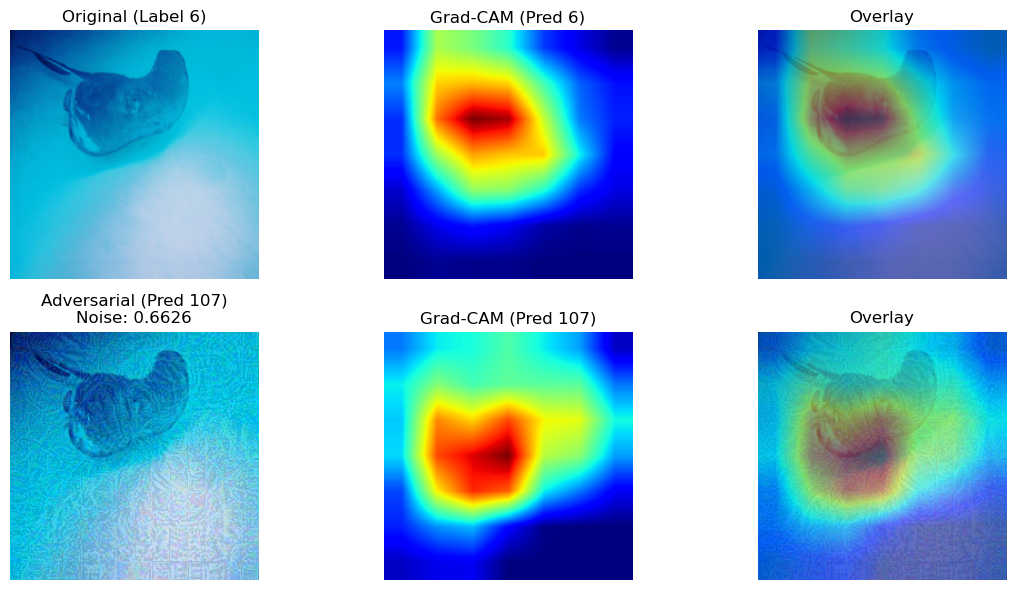

In [82]:
i = 206 # index of sample to visualize
show_cam_comparison(
    get_models("imagenet", "wide_resnet101_2", "wide_resnet101_2"),
    orig_all[i],
    adv_all[i],
    true_label=int(labels_all[i]),
)

In [76]:
import numpy as np

# Suppose noise_rates is your list of 1-SSIM values
threshold = 0.6  # example threshold
noise_rates = np.array(noise_rates)  # convert to numpy array if not already

# Get indices of noise above threshold
indices_above_threshold = np.where(noise_rates > threshold)[0]

print("Indices with noise above threshold:", indices_above_threshold)
print("Corresponding noise values:", noise_rates[indices_above_threshold])

Indices with noise above threshold: [ 10  20  78 117 155 206 213 255 267 327 366 382 411 463 522 570 573 633
 647 652 692 713 743 793 820 829 861 976 982 990]
Corresponding noise values: [0.6147474  0.6000099  0.6456382  0.63209116 0.60413146 0.6606072
 0.62679136 0.6265383  0.6101714  0.6208557  0.6356235  0.63934755
 0.6133455  0.6004528  0.62584555 0.6974708  0.65758824 0.73126125
 0.66422594 0.61920893 0.6034526  0.64211625 0.68510485 0.60489523
 0.67995244 0.64530575 0.65273696 0.6082347  0.6247833  0.80087626]


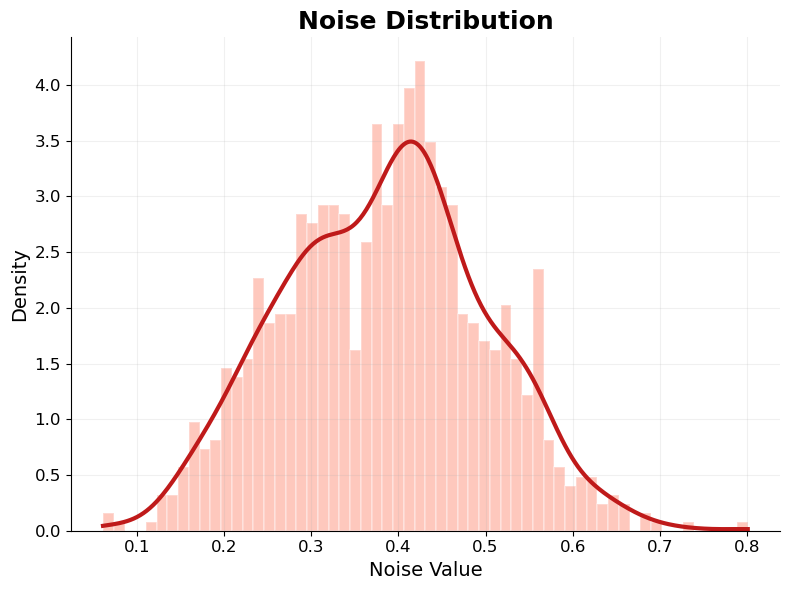

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def beautiful_noise_plot(noises, title="Noise Distribution", save_path=None):
    noises = np.array(noises).flatten()
    kde = gaussian_kde(noises)
    
    xs = np.linspace(noises.min(), noises.max(), 400)
    ys = kde(xs)

    plt.figure(figsize=(8,6))
    
    # histogram
    plt.hist(
        noises, bins=60, density=True, alpha=0.35,
        color="#FE6244", edgecolor="white", linewidth=1.2
    )
    
    # KDE curve
    plt.plot(xs, ys, color="#BF1A1A", linewidth=3)

    # Aesthetic improvements
    plt.grid(alpha=0.18)
    plt.title(title, fontsize=18, weight="bold")
    plt.xlabel("Noise Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Remove top/right borders
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    
    # Save as SVG if path provided
    if save_path is not None:
        plt.savefig(save_path, format='svg')

    plt.show()

# Example usage:
beautiful_noise_plot(noise_rates, save_path="noise_distribution.svg")


In [20]:
import os
from torchvision.utils import save_image

# Base results folder
base_folder = "results"
# Create new folder with a unique name, e.g., timestamp
import time
timestamp = time.strftime("%Y%m%d_%H%M%S")
save_folder = os.path.join(base_folder, f"Exp_2_set_1_SMER_PGD_{timestamp}")
os.makedirs(save_folder, exist_ok=True)

# Save images
for idx, adv_img in enumerate(adv_all):
    # adv_img is in [C,H,W], in 0-1 range (torch.float)
    save_path = os.path.join(save_folder, f"adv_{idx:04d}.png")
    save_image(adv_img, save_path)

print(f"Saved {adv_all.shape[0]} adversarial images to {save_folder}")

Saved 1000 adversarial images to results/Exp_2_set_1_SMER_PGD_20251123_000123
